# TEAM-KMJS (a.k.a Team Sasa)     
### Sprint4 - News 

In [1]:
import spacy
import en_core_web_lg, en_core_web_sm, en_core_web_md

import gensim 
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess

import pyLDAvis.gensim

import numpy as np 
import pandas as pd
import math 

import matplotlib.pyplot as plt 
from wordcloud import WordCloud 

from scipy.sparse import csr_matrix
from sklearn.preprocessing import normalize
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from textblob import TextBlob 
# https://www.loc.gov/standards/iso639-2/php/code_list.php

from collections import  Counter
import string, os, re, operator, warnings
warnings.filterwarnings('ignore')
%matplotlib inline

/usr/local/anaconda3/lib/python3.8/site-packages/ipykernel/pylab/config.py:70: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):
/usr/local/anaconda3/lib/python3.8/site-packages/nltk/decorators.py:67: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  signature = inspect.formatargspec(
/usr/local/anaconda3/lib/python3.8/site-packages/nltk/lm/counter.py:15: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import Sequence, defaultdict
/usr/local/anaconda3/lib/python3.8/site-packages/nltk/lm/vocabulary.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will 

In [2]:
print(f'SpaCy:\t{spacy.__version__}')
print(f'en_core_web_lg:\t{en_core_web_lg.__version__}')
print(f'NLTK:\t{nltk.__version__}')
print(f'gensim:\t{gensim.__version__}')

SpaCy:	3.0.4
en_core_web_lg:	3.0.0
NLTK:	3.4.4
gensim:	3.8.3


In [3]:

### NLP Model
# NLP = en_core_web_lg.load()
NLP = spacy.load('en_core_web_lg', disable=['parser', 'ner'])


### Stop Words
STOPWORDS = stopwords.words('english')
STOPWORDS.extend(['news', 'advertisement', 'rappler', 'gma', 'inquirer', 'manila', 'philippines', 'philippine', 'bulletin', 'star',\
    'cnn', 'abs', 'cbn', 'abscbn', 'abs-cbn', 'sunstar', 'covid', 'covid-19', 'covid19', 'vaccine', 'say'])
print(STOPWORDS)

### Doc Object
def get_doc(text):
    docstring =  str(''.join([i if ord(i) < 128 else ' ' for i in text]))
    return NLP(docstring)


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [4]:
FILENAME = 'datasets/combined_and_cleaned.csv'

df = pd.read_csv(FILENAME)
df['published_dates'] = pd.to_datetime(df['published_dates'])
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370 entries, 0 to 369
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   urls              370 non-null    object        
 1   titles            370 non-null    object        
 2   authors           370 non-null    object        
 3   published_dates   370 non-null    datetime64[ns]
 4   articles_content  370 non-null    object        
 5   news_org          370 non-null    object        
dtypes: datetime64[ns](1), object(5)
memory usage: 17.5+ KB


,urls,titles,authors,published_dates,articles_content,news_org
0,https://www.rappler.com/newsbreak/explainers/w...,Here’s why COVID-19 vaccines haven’t arrived i...,SOFIA TOMACRUZ,2021-02-18 09:22:00,"MANILA, PHILIPPINES\nThe Philippine government...",Rappler
1,https://www.rappler.com/newsbreak/iq/timeline-...,TIMELINE: The Philippines’ 2021 COVID-19 vacci...,SOFIA TOMACRUZ,2021-02-04 19:43:00,"MANILA, PHILIPPINES\n(UPDATED) On March 1, the...",Rappler
2,https://www.rappler.com/nation/philippines-rec...,"After initial delay, Philippines to receive As...",SOFIA TOMACRUZ,2021-03-03 14:41:00,"MANILA, PHILIPPINES\n(UPDATED) Malacañang says...",Rappler
3,https://www.rappler.com/nation/philippines-gra...,Philippines grants emergency approval for Sino...,SOFIA TOMACRUZ,2021-02-22 12:19:00,"MANILA, PHILIPPINES\n(UPDATED) Its lower effic...",Rappler
4,https://www.rappler.com/nation/philippines-rec...,Philippines receives first COVID-19 vaccine de...,SOFIA TOMACRUZ,2021-02-28 16:16:00,"MANILA, PHILIPPINES\n(3rd UPDATE) The arrival ...",Rappler
...,...,...,...,...,...,...
365,https://www.gmanetwork.com/news/scitech/scienc...,UK starts accelerated review for AstraZeneca’s...,KANISHKA SINGH,2020-11-01 21:09:00,AstraZeneca Plc said on Sunday Britain's healt...,GMA News
366,https://www.gmanetwork.com/news/scitech/scienc...,J&J's COVID-19 vaccine produces strong immune ...,NANCY LAPID,2020-09-26 04:06:00,A single dose of Johnson & Johnson's experimen...,GMA News
367,https://www.gmanetwork.com/news/news/regions/7...,COVID-19 vaccine clinical trials for Cavite re...,ANNA FELICIA BAJO,2020-08-28 09:31:00,The clinical trials for vaccines against COVID...,GMA News
368,https://www.gmanetwork.com/news/news/nation/75...,China eyes COVID-19 vaccine by year-end or ear...,NICOLE-ANNE C. LAGRIMAS,2020-09-08 19:09:00,China hopes to be ready with a vaccine against...,GMA News


# TOPIC MODELING
### https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

## Tokenize words and Clean-up text


In [5]:
# Convert to list
data = df['articles_content'].values.tolist()

# Convert R&D to Research and Development
data = [sent.lower().replace('r&d', 'Research and Development') for sent in data]

# Remove URLs
data = [re.sub("(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))", '', sent) for sent in data]

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data = list(sent_to_words(data))

print(data[:1])

[['manila', 'philippines', 'the', 'philippine', 'government', 'needs', 'key', 'measure', 'on', 'indemnification', 'funds', 'to', 'be', 'signed', 'into', 'law', 'philippine', 'pandemic', 'officials', 'announced', 'the', 'delivery', 'of', 'the', 'country', 'first', 'batch', 'of', 'coronavirus', 'vaccines', 'could', 'be', 'expected', 'by', 'mid', 'february', 'but', 'with', 'that', 'timeline', 'looking', 'less', 'likely', 'to', 'be', 'met', 'the', 'duterte', 'government', 'task', 'force', 'officials', 'announced', 'there', 'would', 'be', 'slight', 'delay', 'in', 'the', 'arrival', 'of', 'vaccines', 'due', 'to', 'of', 'all', 'things', 'paperwork', 'vaccine', 'czar', 'carlito', 'galvez', 'jr', 'and', 'national', 'task', 'force', 'covid', 'deputy', 'chief', 'implementer', 'vince', 'dizon', 'pointed', 'to', 'documentary', 'requirements', 'involving', 'an', 'indemnification', 'fund', 'as', 'the', 'culprit', 'behind', 'the', 'delayed', 'schedule', 'why', 'do', 'we', 'need', 'an', 'indemnification

## Creating Bigram and Trigram Models

In [6]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data[0]]])

['manila', 'philippines', 'the', 'philippine', 'government', 'needs', 'key', 'measure', 'on', 'indemnification', 'funds', 'to', 'be', 'signed', 'into', 'law', 'philippine', 'pandemic', 'officials', 'announced', 'the', 'delivery', 'of', 'the', 'country', 'first', 'batch', 'of', 'coronavirus', 'vaccines', 'could', 'be', 'expected', 'by', 'mid_february', 'but', 'with', 'that', 'timeline', 'looking', 'less', 'likely', 'to', 'be', 'met', 'the', 'duterte', 'government', 'task_force', 'officials', 'announced', 'there', 'would', 'be', 'slight', 'delay', 'in', 'the', 'arrival', 'of', 'vaccines', 'due', 'to', 'of', 'all', 'things', 'paperwork', 'vaccine', 'czar_carlito_galvez_jr', 'and', 'national_task_force', 'covid', 'deputy', 'chief_implementer', 'vince_dizon', 'pointed', 'to', 'documentary', 'requirements', 'involving', 'an', 'indemnification_fund', 'as', 'the', 'culprit', 'behind', 'the', 'delayed', 'schedule', 'why', 'do', 'we', 'need', 'an', 'indemnification_fund', 'an', 'indemnification_

## Remove Stopwords, Make Bigrams and Lemmatize


In [7]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in gensim.utils.simple_preprocess(str(doc)) if word not in STOPWORDS] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    # https://spacy.io/api/annotation
    texts_out = []
    for sent in texts:
        doc = NLP(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


In [8]:
# Remove Stop Words
data = remove_stopwords(data)

# Form Bigrams
data = make_bigrams(data)

# Do lemmatization keeping only noun, adj, vb, adv
data = lemmatization(data)

print(data[:1])

[['government', 'need', 'key', 'measure', 'indemnification', 'fund', 'sign', 'law', 'pandemic', 'official', 'announce', 'delivery', 'country', 'first', 'batch', 'coronavirus', 'vaccine', 'expect', 'mid_february', 'timeline', 'look', 'less', 'likely', 'meet', 'government', 'official', 'announce', 'slight', 'delay', 'arrival', 'vaccine', 'due', 'thing', 'paperwork', 'force', 'deputy', 'point', 'documentary', 'requirement', 'involve', 'culprit', 'delay', 'schedule', 'need', 'galvez', 'early', 'tell', 'lawmaker', 'congressional', 'hearing', 'necessary', 'gain', 'access', 'dose', 'pharmaceutical_companie', 'well', 'covax', 'global', 'facility', 'request', 'lawmaker', 'consider', 'bill', 'provide', 'mid', 'january', 'add', 'give', 'opportunity', 'gain', 'access', 'large', 'supply', 'vaccine', 'increase', 'public', 'confidence', 'government', 'rollout', 'reason', 'indemnification', 'fund', 'program', 'require', 'country', 'vaccine', 'use', 'worldwide', 'still', 'limit', 'short', 'term', 'datu

In [9]:
# Create Dictionary
id2word_dictionary = Dictionary(data)

# Create Corpus
texts = data

# Term Document Frequency
corpus = [id2word_dictionary.doc2bow(text) for text in texts]

# View
print(corpus[:1])

# Human readable format of corpus (term-frequency)
# [(id2word_dictionary[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[(0, 2), (1, 1), (2, 4), (3, 1), (4, 1), (5, 2), (6, 1), (7, 1), (8, 1), (9, 3), (10, 2), (11, 1), (12, 1), (13, 8), (14, 1), (15, 1), (16, 1), (17, 1), (18, 3), (19, 5), (20, 1), (21, 1), (22, 2), (23, 2), (24, 1), (25, 2), (26, 2), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 2), (34, 3), (35, 1), (36, 1), (37, 1), (38, 1), (39, 2), (40, 1), (41, 1), (42, 12), (43, 1), (44, 5), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 4), (51, 2), (52, 1), (53, 1), (54, 2), (55, 1), (56, 1), (57, 2), (58, 3), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 9), (65, 1), (66, 2), (67, 1), (68, 1), (69, 1), (70, 1), (71, 6), (72, 7), (73, 1), (74, 3), (75, 1), (76, 2), (77, 1), (78, 1), (79, 3), (80, 1), (81, 1), (82, 1), (83, 3), (84, 2), (85, 1), (86, 1), (87, 1), (88, 3), (89, 1), (90, 2), (91, 3), (92, 1), (93, 1), (94, 1), (95, 1), (96, 2), (97, 1), (98, 2), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (105, 2), (106, 1), (107, 2), (108, 3), (109, 1), (110, 3

## Building the Topic Model

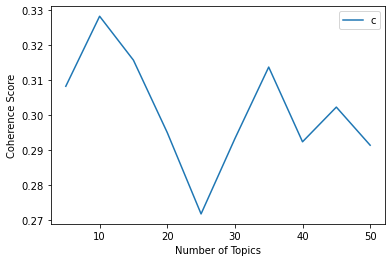

Model[0] ~> N-Topics ~>  5 has Coherence Value of ~> 0.3083
Model[1] ~> N-Topics ~> 10 has Coherence Value of ~> 0.3283
Model[2] ~> N-Topics ~> 15 has Coherence Value of ~> 0.3157
Model[3] ~> N-Topics ~> 20 has Coherence Value of ~> 0.295
Model[4] ~> N-Topics ~> 25 has Coherence Value of ~> 0.2717
Model[5] ~> N-Topics ~> 30 has Coherence Value of ~> 0.2933
Model[6] ~> N-Topics ~> 35 has Coherence Value of ~> 0.3138
Model[7] ~> N-Topics ~> 40 has Coherence Value of ~> 0.2924
Model[8] ~> N-Topics ~> 45 has Coherence Value of ~> 0.3023
Model[9] ~> N-Topics ~> 50 has Coherence Value of ~> 0.2914
CPU times: user 40.2 s, sys: 8.74 s, total: 49 s
Wall time: 3min 3s


In [10]:
%%time 

limit = 51; start = 5; step = 5
coherences = []
models = []

for N in range(start, limit, step):
    ldamodel = LdaModel(corpus=corpus, num_topics=N, id2word=id2word_dictionary)
    models.append(ldamodel)

    ldatopics = [[word for word, prob in topic] for topicid, topic in ldamodel.show_topics(formatted=False)]
    ldacoherence = CoherenceModel(topics=ldatopics[:10], texts=texts, dictionary=id2word_dictionary, window_size=10).get_coherence()
    coherences.append((ldacoherence))


# Plot the number of topics based on coherence score
x = range(start, limit, step)
plt.plot(x, coherences)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.legend('coherences', loc='best')
plt.show()  


# Print the coherence scores
idx = 0
for n, cv in zip(x, coherences):
    print(f'Model[{idx}] ~> N-Topics ~> {n:2} has Coherence Value of ~> {round(cv, 4)}')
    idx += 1

In [11]:
# Select the BEST model and print the topics
best_model = models[0]
topics = best_model.show_topics(formatted=False)
print(best_model.print_topics(num_words=10))

[(0, '0.028*"say" + 0.017*"vaccine" + 0.012*"dose" + 0.012*"government" + 0.009*"country" + 0.008*"health" + 0.006*"first" + 0.006*"also" + 0.006*"astrazeneca" + 0.005*"pfizer"'), (1, '0.035*"say" + 0.019*"vaccine" + 0.011*"dose" + 0.008*"government" + 0.008*"astrazeneca" + 0.008*"trial" + 0.007*"health" + 0.007*"country" + 0.006*"early" + 0.006*"get"'), (2, '0.025*"say" + 0.010*"vaccine" + 0.009*"health" + 0.008*"dose" + 0.007*"first" + 0.007*"government" + 0.005*"trial" + 0.005*"country" + 0.005*"world" + 0.004*"ng"'), (3, '0.019*"say" + 0.012*"vaccine" + 0.010*"dose" + 0.008*"health" + 0.006*"also" + 0.006*"country" + 0.006*"government" + 0.005*"first" + 0.005*"trial" + 0.005*"get"'), (4, '0.024*"say" + 0.023*"vaccine" + 0.011*"health" + 0.010*"dose" + 0.009*"government" + 0.006*"country" + 0.006*"get" + 0.006*"astrazeneca" + 0.005*"also" + 0.005*"sinovac"')]


In [12]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(best_model, corpus, id2word_dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.007044  0.001320       1        1  36.578461
0      0.010463  0.006350       2        1  27.417636
4      0.010879 -0.008059       3        1  18.812970
3     -0.013514  0.013053       4        1   9.436339
2     -0.014872 -0.012664       5        1   7.754594, topic_info=            Term         Freq        Total Category  logprob  loglift
295          say  2212.000000  2212.000000  Default  30.0000  30.0000
154       health   661.000000   661.000000  Default  29.0000  29.0000
349      vaccine  1365.000000  1365.000000  Default  28.0000  28.0000
107         dose   838.000000   838.000000  Default  27.0000  27.0000
138        first   424.000000   424.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
29   astrazeneca    22.099747   471.130750   Topic5  -5.5990  -0.5027
146          get    20.031897   404.481155   Topic5  -5.6972  -0.4484
110        early    19.535598   384.789054   Topic5  -5.7223  -0.4236
348  vaccination    18.588581   323.945696   Topic5  -5.7720  -0.3011
529       worker    16.741474   223.676639   Topic5  -5.8767  -0.0354

[433 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
5682      5  0.659465         abby
362       1  0.336616  abeyasinghe
362       2  0.504923  abeyasinghe
362       3  0.084154  abeyasinghe
362       4  0.042077  abeyasinghe
...     ...       ...          ...
358       4  0.112452         year
358       5  0.063560         year
4158      1  0.317546         zone
4158      2  0.317546         zone
4158      5  0.317546         zone

[990 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 5, 4, 3])

## Finding the dominant topic in each sentence

In [13]:
def format_topics_sentences(ldamodel=best_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['dominant_topic', 'percentage_contribution', 'topic_keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=best_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['document_id', 'dominant_topic', 'topic_percentage_contribution', 'keywords', 'text']
# df_dominant_topic = df_dominant_topic.drop('document_id', axis=1)

# Show
# print(f'{df_dominant_topic.shape[0]} == {df.shape[0]}')
df_dominant_topic

,document_id,dominant_topic,topic_percentage_contribution,keywords,text
0,0,0.0,0.9950,"say, vaccine, dose, government, country, healt...","[government, need, key, measure, indemnificati..."
1,1,0.0,0.8576,"say, vaccine, dose, government, country, healt...","[update, march, finally, begin, legally, roll,..."
2,2,1.0,0.6221,"say, vaccine, dose, government, astrazeneca, t...","[update, malacanang, say, dose, covax, global,..."
3,3,1.0,0.5327,"say, vaccine, dose, government, astrazeneca, t...","[update, low, efficacy, trial, lead, expert, r..."
4,4,0.0,0.7510,"say, vaccine, dose, government, country, healt...","[rd, update, arrival, donate, vaccine, china, ..."
...,...,...,...,...,...
365,365,0.0,0.5514,"say, vaccine, dose, government, country, healt...","[astrazeneca, say, sunday, britain, health, re..."
366,366,0.0,0.9966,"say, vaccine, dose, government, country, healt...","[single, dose, johnson, johnsons, experimental..."
367,367,2.0,0.9765,"say, vaccine, health, dose, first, government,...","[clinical_trial, vaccine, involve, cavite, res..."
368,368,1.0,0.9933,"say, vaccine, dose, government, astrazeneca, t...","[china, hope, ready, end, year, early, chinese..."


## Find the most representative document for each topic

In [14]:
# Group top 5 sentences under each topic
sent_topics_sorteddf = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('dominant_topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, grp.sort_values(['percentage_contribution'], ascending=[0]).head(1)], axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['topic_id', "topic_percentage_contribution", "keywords", "text"]

# ### Save the dataset as CSV
# sent_topics_sorteddf.to_csv('datasets/topics.csv')

# Show
print(sent_topics_sorteddf.shape)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
sent_topics_sorteddf

(5, 4)


,topic_id,topic_percentage_contribution,keywords,text
0,0.0,0.9971,"say, vaccine, dose, government, country, health, first, also, astrazeneca, pfizer","[requirement, standard, agreement, common, country, re, specific, relate, dengvaxia, say, representative, world, health, organization, representative, rabindra_abeyasinghe, deny, ask, specific, requirement, indemnification, agreement, firm, pfizer, due, dengvaxia, dengue, controversy, contrary, claim, make, early, say, arrest, warrant, issue, relation, dengvaxia, scandal, impact, government, negotiation, effort, manufacturer, galvez, attribute, delay, procurement, dengvaxia, issue, told_reporter, situation, change, understand, happen, warrant, arrest, sanofi, great, implication, procurement, really, add, arrest, warrant, announce, last, february, change, virtual_briefe, tuesday, abeyasinghe, clarify, instead, ask, sign, standard, indemnification, agreement, similar, present, different, country, receive, developed, let, clarify, requirement, standard, agreement, common, country, re, specific, related, issue, happen, country, relate, dengvaxia, ...]"
1,1.0,0.9980,"say, vaccine, dose, government, astrazeneca, trial, health, country, early, get","[paris, dozen, company, biotech, start, up, big, pharma, racing, develop, safe, effective, coronavirus, meet, urgent, medical, need, potential, payday, positive, result, final, stage, trial, several, candidate, raise, hope, light, end, tunnel, quest, curb, pandemic, already, kill, nearly, people, worldwide, many, pipeline, world, health, organization, identify, candidate, vaccine, stage, clinical_trial, human, mid, june, advanced, phase, stage, vaccine, effectiveness, test, large_scale, generally, ten, thousand, people, several, continent, story, pandemic, inflame, violence, woman, new, case, bring, tally, typhoon, evacuee, rizal, undergo, swab, test, european, project, lead, university, oxford, astrazeneca, say, phase, trial, show, average, percent, efficacy, trial, involve, people, statement, say, drug, show, ...]"
2,2.0,0.9971,"say, vaccine, health, dose, first, government, trial, country, world, ng","[identification, system, philsys, national, i, d, potentially, use, government, target, distribution, priority_group, national, economic, development, authority, neda, say, wednesday, role, neda, member, actually, offer, secretary_carlito, galvez, heading, possibility, use, national, i, d, basis, distribution, act, socioeconomic, planning, secretary, say, virtual, sa, bay, forum, really, health, response, neda, health, expert, expert, national, d, help, aspect, say, nearly, filipino, compose, frontline, health, worker, poor, first, receive, country, eye, begin, mass, immunization, program, first, half, force, early, say, government, target, inoculate, population, sufficient, create, herd_immunity, story, effective, minimum, neda, typhoon, transport, restriction, push, inflation, high, november, neda, ncr, worker, unable, go, work, september, ...]"
3,3.0,0.9968,"say, vaccine, dose, health, also, country, government, first, trial, get","[follow, roundup, late, scientific, study, effort, find, treatment, vaccine, illness, cause, virus, variant, likely, reinfect, survivor, coronavirus, variant, circulate, likely, able, reinfect, people, survive, infection, early, version, coronavirus, new, datum, suggest, variant, emerge, brazil, call, carry, mutation, already, know, make, variant, prevalent, south_africa, hard, treat, antibody, hard, prevent, available, vaccine, new, datum, suggest, many, recover, patient, immunity, early, version, virus, afford, immunity, story, sinovac, trigger, sufficient, antibody, response, variant, study, say, report, china, mission, origin, due, mid, march, japan, supercomputer, show, double, mask, offer, little, help, prevent, viral, spread, researcher, test, neutralize, ability, antibody, plasma, sample, take, survivor, cause, early, ...]"
4,4.0,0.9986,"say, vaccine, health, dose, government, country, get, astrazenec

## Topic distribution across documents

In [15]:
pd.reset_option('^display', silent=True)

# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['dominant_topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['dominant_topic', 'topic_keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['dominant_topic', 'topic_keywords', 'num_documents', 'percentage_documents']

# Show
# df_dominant_topics = df_dominant_topics[~df_dominant_topics['num_documents'].isna()][['topic_keywords']]
df_dominant_topics

,dominant_topic,topic_keywords,num_documents,percentage_documents
0.0,0.0,"say, vaccine, dose, government, country, healt...",92.0,0.2486
1.0,0.0,"say, vaccine, dose, government, country, healt...",142.0,0.3838
2.0,1.0,"say, vaccine, dose, government, astrazeneca, t...",35.0,0.0946
3.0,1.0,"say, vaccine, dose, government, astrazeneca, t...",33.0,0.0892
4.0,0.0,"say, vaccine, dose, government, country, healt...",68.0,0.1838
...,...,...,...,...
365.0,0.0,"say, vaccine, dose, government, country, healt...",NaN,NaN
366.0,0.0,"say, vaccine, dose, government, country, healt...",NaN,NaN
367.0,2.0,"say, vaccine, health, dose, first, government,...",NaN,NaN
368.0,1.0,"say, vaccine, dose, government, astrazeneca, t...",NaN,NaN


# FINAL DF

In [16]:
sia = SentimentIntensityAnalyzer()

def get_vader_polarity(text):
    return sia.polarity_scores(text)['compound']

def get_vader_negativity(text):
    return sia.polarity_scores(text)['neg']

def get_vader_neutrality(text):
    return sia.polarity_scores(text)['neu']

def get_vader_positivity(text):
    return sia.polarity_scores(text)['pos']

def get_polarity(text):
    return TextBlob(text).sentiment.polarity

def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def get_analysis(score):
    if score <= -0.05:
        return 'Negative'
    elif score >= 0.05:
        return 'Positive'
    else:
        return 'Neutral'

In [17]:
df = pd.concat([df, df_dominant_topic.reindex(df.index)], axis=1).drop('document_id', axis=1)
df

,urls,titles,authors,published_dates,articles_content,news_org,dominant_topic,topic_percentage_contribution,keywords,text
0,https://www.rappler.com/newsbreak/explainers/w...,Here’s why COVID-19 vaccines haven’t arrived i...,SOFIA TOMACRUZ,2021-02-18 09:22:00,"MANILA, PHILIPPINES\nThe Philippine government...",Rappler,0.0,0.9950,"say, vaccine, dose, government, country, healt...","[government, need, key, measure, indemnificati..."
1,https://www.rappler.com/newsbreak/iq/timeline-...,TIMELINE: The Philippines’ 2021 COVID-19 vacci...,SOFIA TOMACRUZ,2021-02-04 19:43:00,"MANILA, PHILIPPINES\n(UPDATED) On March 1, the...",Rappler,0.0,0.8576,"say, vaccine, dose, government, country, healt...","[update, march, finally, begin, legally, roll,..."
2,https://www.rappler.com/nation/philippines-rec...,"After initial delay, Philippines to receive As...",SOFIA TOMACRUZ,2021-03-03 14:41:00,"MANILA, PHILIPPINES\n(UPDATED) Malacañang says...",Rappler,1.0,0.6221,"say, vaccine, dose, government, astrazeneca, t...","[update, malacanang, say, dose, covax, global,..."
3,https://www.rappler.com/nation/philippines-gra...,Philippines grants emergency approval for Sino...,SOFIA TOMACRUZ,2021-02-22 12:19:00,"MANILA, PHILIPPINES\n(UPDATED) Its lower effic...",Rappler,1.0,0.5327,"say, vaccine, dose, government, astrazeneca, t...","[update, low, efficacy, trial, lead, expert, r..."
4,https://www.rappler.com/nation/philippines-rec...,Philippines receives first COVID-19 vaccine de...,SOFIA TOMACRUZ,2021-02-28 16:16:00,"MANILA, PHILIPPINES\n(3rd UPDATE) The arrival ...",Rappler,0.0,0.7510,"say, vaccine, dose, government, country, healt...","[rd, update, arrival, donate, vaccine, china, ..."
...,...,...,...,...,...,...,...,...,...,...
365,https://www.gmanetwork.com/news/scitech/scienc...,UK starts accelerated review for AstraZeneca’s...,KANISHKA SINGH,2020-11-01 21:09:00,AstraZeneca Plc said on Sunday Britain's healt...,GMA News,0.0,0.5514,"say, vaccine, dose, government, country, healt...","[astrazeneca, say, sunday, britain, health, re..."
366,https://www.gmanetwork.com/news/scitech/scienc...,J&J's COVID-19 vaccine produces strong immune ...,NANCY LAPID,2020-09-26 04:06:00,A single dose of Johnson & Johnson's experimen...,GMA News,0.0,0.9966,"say, vaccine, dose, government, country, healt...","[single, dose, johnson, johnsons, experimental..."
367,https://www.gmanetwork.com/news/news/regions/7...,COVID-19 vaccine clinical trials for Cavite re...,ANNA FELICIA BAJO,2020-08-28 09:31:00,The clinical trials for vaccines against COVID...,GMA News,2.0,0.9765,"say, vaccine, health, dose, first, government,...","[clinical_trial, vaccine, involve, cavite, res..."
368,https://www.gmanetwork.com/news/news/nation/75...,China eyes COVID-19 vaccine by year-end or ear...,NICOLE-ANNE C. LAGRIMAS,2020-09-08 19:09:00,China hopes to be ready with a vaccine against...,GMA News,1.0,0.9933,"say, vaccine, dose, government, astrazeneca, t...","[china, hope, ready, end, year, early, chinese..."


In [18]:
# Data Analysis
df['polarity'] = df['text'].str.join(' ').apply(get_vader_polarity)
df['negativity'] = df['text'].str.join(' ').apply(get_vader_negativity)
df['neutrality'] = df['text'].str.join(' ').apply(get_vader_neutrality)
df['positivity'] = df['text'].str.join(' ').apply(get_vader_positivity)
df['subjectivity'] = df['text'].str.join(' ').apply(get_subjectivity)
df['analysis'] = df['polarity'].apply(get_analysis)

# Save the model dataset as CSV
FILENAME = 'datasets/model.csv'
df.to_csv(FILENAME, index=False)


In [19]:
### Read the MODEL dataset
df = pd.read_csv(FILENAME)
df['published_dates'] = pd.to_datetime(df['published_dates'])
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370 entries, 0 to 369
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   urls                           370 non-null    object        
 1   titles                         370 non-null    object        
 2   authors                        370 non-null    object        
 3   published_dates                370 non-null    datetime64[ns]
 4   articles_content               370 non-null    object        
 5   news_org                       370 non-null    object        
 6   dominant_topic                 370 non-null    float64       
 7   topic_percentage_contribution  370 non-null    float64       
 8   keywords                       370 non-null    object        
 9   text                           370 non-null    object        
 10  polarity                       370 non-null    float64       
 11  negativity         

,urls,titles,authors,published_dates,articles_content,news_org,dominant_topic,topic_percentage_contribution,keywords,text,polarity,negativity,neutrality,positivity,subjectivity,analysis
0,https://www.rappler.com/newsbreak/explainers/w...,Here’s why COVID-19 vaccines haven’t arrived i...,SOFIA TOMACRUZ,2021-02-18 09:22:00,"MANILA, PHILIPPINES\nThe Philippine government...",Rappler,0.0,0.9950,"say, vaccine, dose, government, country, healt...","['government', 'need', 'key', 'measure', 'inde...",0.9842,0.084,0.786,0.131,0.389224,Positive
1,https://www.rappler.com/newsbreak/iq/timeline-...,TIMELINE: The Philippines’ 2021 COVID-19 vacci...,SOFIA TOMACRUZ,2021-02-04 19:43:00,"MANILA, PHILIPPINES\n(UPDATED) On March 1, the...",Rappler,0.0,0.8576,"say, vaccine, dose, government, country, healt...","['update', 'march', 'finally', 'begin', 'legal...",0.9892,0.011,0.886,0.103,0.374242,Positive
2,https://www.rappler.com/nation/philippines-rec...,"After initial delay, Philippines to receive As...",SOFIA TOMACRUZ,2021-03-03 14:41:00,"MANILA, PHILIPPINES\n(UPDATED) Malacañang says...",Rappler,1.0,0.6221,"say, vaccine, dose, government, astrazeneca, t...","['update', 'malacanang', 'say', 'dose', 'covax...",0.8251,0.064,0.805,0.131,0.353750,Positive
3,https://www.rappler.com/nation/philippines-gra...,Philippines grants emergency approval for Sino...,SOFIA TOMACRUZ,2021-02-22 12:19:00,"MANILA, PHILIPPINES\n(UPDATED) Its lower effic...",Rappler,1.0,0.5327,"say, vaccine, dose, government, astrazeneca, t...","['update', 'low', 'efficacy', 'trial', 'lead',...",0.9666,0.095,0.743,0.162,0.382554,Positive
4,https://www.rappler.com/nation/philippines-rec...,Philippines receives first COVID-19 vaccine de...,SOFIA TOMACRUZ,2021-02-28 16:16:00,"MANILA, PHILIPPINES\n(3rd UPDATE) The arrival ...",Rappler,0.0,0.7510,"say, vaccine, dose, government, country, healt...","['rd', 'update', 'arrival', 'donate', 'vaccine...",0.7334,0.065,0.860,0.075,0.296780,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365,https://www.gmanetwork.com/news/scitech/scienc...,UK starts accelerated review for AstraZeneca’s...,KANISHKA SINGH,2020-11-01 21:09:00,AstraZeneca Plc said on Sunday Britain's healt...,GMA News,0.0,0.5514,"say, vaccine, dose, government, country, healt...","['astrazeneca', 'say', 'sunday', 'britain', 'h...",-0.9393,0.131,0.826,0.043,0.422408,Negative
366,https://www.gmanetwork.com/news/scitech/scienc...,J&J's COVID-19 vaccine produces strong immune ...,NANCY LAPID,2020-09-26 04:06:00,A single dose of Johnson & Johnson's experimen...,GMA News,0.0,0.9966,"say, vaccine, dose, government, country, healt...","['single', 'dose', 'johnson', 'johnsons', 'exp...",0.8689,0.103,0.770,0.127,0.426386,Positive
367,https://www.gmanetwork.com/news/news/regions/7...,COVID-19 vaccine clinical trials for Cavite re...,ANNA FELICIA BAJO,2020-08-28 09:31:00,The clinical trials for vaccines against COVID...,GMA News,2.0,0.9765,"say, vaccine, health, dose, first, government,...","['clinical_trial', 'vaccine', 'involve', 'cavi...",-0.1531,0.087,0.811,0.102,0.284975,Negative
368,https://www.gmanetwork.com/news/news/nation/75...,China eyes COVID-19 vaccine by year-end or ear...,NICOLE-ANNE C. LAGRIMAS,2020-09-08 19:09:00,China hopes to be ready with a vaccine against...,GMA News,1.0,0.9933,"say, vaccine, dose, government, astrazeneca, t...","['china', 'hope', 'ready', 'end', 'year', 'ear...",0.9714,0.047,0.742,0.211,0.348611,Positive


In [20]:
import plotly.express as px

fig = px.scatter(df,
                x='polarity',
                y='subjectivity',
                color='analysis',
                size='subjectivity'
                )

fig.update_layout(title='Sentiment Analysis',
                shapes=[dict(
                    type='line',
                    yref='paper', y0=0, y1=1,
                    xref='x', x0=0, x1=0
                )]
                )

fig.show()

In [21]:
# def to_english(text):
#     tb = TextBlob(u'{text}')
#     result = text
#     try:
#         result = str(tb.translate(to='en'))
#     except:
#         pass
#     return result

# def to_tagalog(text):
#     tb = TextBlob(u'{text}')
#     result = text
#     try:
#         result = str(tb.translate(to='tl'))
#     except:
#         pass
#     return result
